# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8MB 26kB/s 
     |████████████████████████████████| 3.9MB 26.9MB/s 
     |████████████████████████████████| 450kB 33.6MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf
2.1.0
2.2.4-tf


# Загружаем данные

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

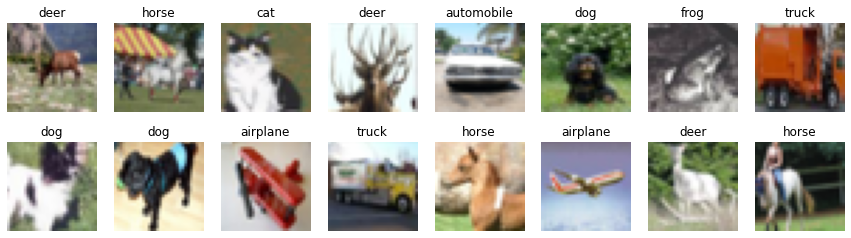

In [6]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [8]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [9]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [10]:
def make_default_model():
    model = M.Sequential()
    model.add(L.Conv2D(16, kernel_size=(3,3), strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.Conv2D(64, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='relu'))
    return model

In [12]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

По итогам конструирования архитектуры сеты, получилась дефолтная сеть с 1084234 числом параметров - очень много!


# Тренируем модель

In [13]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [14]:
# учим дефолтную архитектуру
train_model()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 452us/sample - loss: 2.2229 - accuracy: 0.2499 - val_loss: 1.9171 - val_accuracy: 0.3600
Epoch 2/10
50000/50000 [==============================] - 16s 322us/sample - loss: 2.1626 - accuracy: 0.2200 - val_loss: 1.9836 - val_accuracy: 0.3113
Epoch 3/10
50000/50000 [==============================] - 17s 336us/sample - loss: 2.0922 - accuracy: 0.2683 - val_loss: 1.9822 - val_accuracy: 0.2830
Epoch 4/10
50000/50000 [==============================] - 16s 326us/sample - loss: 2.2255 - accuracy: 0.2520 - val_loss: 1.9975 - val_accuracy: 0.2924
Epoch 5/10
50000/50000 [==============================] - 16s 328us/sample - loss: 2.0067 - accuracy: 0.2879 - val_loss: 1.8935 - val_accuracy: 0.3274
Epoch 6/10
50000/50000 [==============================] - 16s 325us/sample - loss: 1.9912 - accuracy: 0.3318 - val_loss: 1.9265 - val_accuracy: 0.3482
Epoch 7/10
50000/50000 [====================

После обучения дефолтной архитектуры получились точность на трейне accuracy: 0.4109 и точность на тесте val_accuracy: 0.4615, что очень низко!


In [16]:
def make_sigmoid_model():
    model = M.Sequential()
    model.add(L.Conv2D(16, kernel_size=(3,3), strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.Conv2D(64, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='sigmoid'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='sigmoid'))
    return model

In [17]:
K.clear_session()
model = make_sigmoid_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [18]:
# учим sigmoid
train_model(make_sigmoid_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 19s 374us/sample - loss: 1.5000 - accuracy: 0.4635 - val_loss: 1.1160 - val_accuracy: 0.6068
Epoch 2/10
50000/50000 [==============================] - 17s 339us/sample - loss: 1.1659 - accuracy: 0.5897 - val_loss: 0.9998 - val_accuracy: 0.6501
Epoch 3/10
50000/50000 [==============================] - 17s 335us/sample - loss: 1.0844 - accuracy: 0.6239 - val_loss: 0.9653 - val_accuracy: 0.6587
Epoch 4/10
50000/50000 [==============================] - 17s 339us/sample - loss: 1.0563 - accuracy: 0.6293 - val_loss: 0.9609 - val_accuracy: 0.6648
Epoch 5/10
50000/50000 [==============================] - 17s 334us/sample - loss: 1.0515 - accuracy: 0.6308 - val_loss: 0.9733 - val_accuracy: 0.6581
Epoch 6/10
50000/50000 [==============================] - 17s 332us/sample - loss: 1.0483 - accuracy: 0.6329 - val_loss: 0.9630 - val_accuracy: 0.6651
Epoch 7/10
50000/50000 [====================

После изменения функции активации с relu на sigmoid качество значительно улушилось! accuracy: 0.6149, точность на тесте получилась даже вше валидации, и уже больше 65% val_accuracy: 0.6537

In [19]:
# учим sgd
K.clear_session()
model = make_default_model()
train_model(optimizer="sgd")

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 17s 349us/sample - loss: 2.2756 - accuracy: 0.1809 - val_loss: 1.9972 - val_accuracy: 0.3043
Epoch 2/10
50000/50000 [==============================] - 16s 329us/sample - loss: 2.1688 - accuracy: 0.1977 - val_loss: 2.0317 - val_accuracy: 0.2411
Epoch 3/10
50000/50000 [==============================] - 16s 328us/sample - loss: 2.1642 - accuracy: 0.1842 - val_loss: 2.2551 - val_accuracy: 0.1075
Epoch 4/10
50000/50000 [==============================] - 16s 330us/sample - loss: 2.1844 - accuracy: 0.1923 - val_loss: 2.0550 - val_accuracy: 0.2743
Epoch 5/10
50000/50000 [==============================] - 16s 329us/sample - loss: 2.1689 - accuracy: 0.1580 - val_loss: 2.0705 - val_accuracy: 0.2357
Epoch 6/10
50000/50000 [==============================] - 17s 332us/sample - loss: 2.0564 - accuracy: 0.2586 - val_loss: 1.9757 - val_accuracy: 0.3045
Epoch 7/10
50000/50000 [====================

Изменение алгоритма оптимизации значительно снизило качество

In [20]:
def make_bn_model():
    model = M.Sequential()
    model.add(L.Conv2D(16, kernel_size=(3,3), strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='relu'))
    return model

In [21]:
# учим bn
train_model(make_bn_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 21s 427us/sample - loss: 3.7979 - accuracy: 0.2456 - val_loss: 3.0896 - val_accuracy: 0.2855
Epoch 2/10
50000/50000 [==============================] - 20s 402us/sample - loss: 3.5512 - accuracy: 0.2317 - val_loss: 2.9545 - val_accuracy: 0.2637
Epoch 3/10
50000/50000 [==============================] - 20s 401us/sample - loss: 2.8245 - accuracy: 0.2482 - val_loss: 2.2262 - val_accuracy: 0.2573
Epoch 4/10
50000/50000 [==============================] - 20s 398us/sample - loss: 2.4550 - accuracy: 0.2473 - val_loss: 2.2741 - val_accuracy: 0.2416
Epoch 5/10
50000/50000 [==============================] - 20s 398us/sample - loss: 2.2680 - accuracy: 0.2406 - val_loss: 2.0026 - val_accuracy: 0.2967
Epoch 6/10
50000/50000 [==============================] - 20s 393us/sample - loss: 2.0644 - accuracy: 0.2888 - val_loss: 1.9904 - val_accuracy: 0.3236
Epoch 7/10
50000/50000 [====================

батч-нормализация дает прирост в качестве

In [ ]:
def make_sigmoid_bn_model():
    model = M.Sequential()
    model.add(L.Conv2D(16, kernel_size=(3,3), strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=(3,3), strides=1, padding='same'))
    model.add(L.BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='sigmoid'))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='sigmoid'))
    return model

In [ ]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 19s 380us/sample - loss: 1.6897 - accuracy: 0.3950 - val_loss: 1.4292 - val_accuracy: 0.4890
Epoch 2/10
50000/50000 [==============================] - 18s 353us/sample - loss: 1.3422 - accuracy: 0.5259 - val_loss: 1.2320 - val_accuracy: 0.5727
Epoch 3/10
50000/50000 [==============================] - 18s 351us/sample - loss: 1.2045 - accuracy: 0.5754 - val_loss: 1.0378 - val_accuracy: 0.6406
Epoch 4/10
50000/50000 [==============================] - 17s 346us/sample - loss: 1.1296 - accuracy: 0.6030 - val_loss: 0.9729 - val_accuracy: 0.6594
Epoch 5/10
50000/50000 [==============================] - 17s 347us/sample - loss: 1.0322 - accuracy: 0.6392 - val_loss: 0.8992 - val_accuracy: 0.6900
Epoch 7/10
50000/50000 [==============================] - 17s 347us/sample - loss: 0.9986 - accuracy: 0.6518 - val_loss: 0.8910 - val_accuracy: 0.6890
Epoch 8/10
50000/50000 [====================

Итоговый микс с функцией активации сигмоида и батч нормализация дали значительный прирост в качестве: accuracy: 0.6803, качество на тесте val_accuracy: 0.7035
